In [1]:
import os

from coffea import processor
from coffea.nanoevents import NanoEventsFactory, BaseSchema

import hist
import awkward as ak
import numpy as np
import sys

sys.path.append('/afs/crc.nd.edu/user/a/atownse2/Public/RSTriPhoton')

from analysis.tools import kinematics
from analysis.metadata import sample_info
from analysis.objects import get_photons, get_diphotons, get_triphotons

import matplotlib as mpl

from plots import plotting as p
%matplotlib widget

import importlib



plot_dir = 'plots/bkg/'

In [2]:
class BackgroundProcessor(processor.ProcessorABC):
    def __init__(self, trigger_index=None):
        self.trigger_index = trigger_index
    
    @property
    def accumulator(self):
        dataset_axis=hist.axis.StrCategory([], name='dataset', growth=True, label='Primary dataset')
        diphoton_mass_axis = hist.axis.Regular(32, 0, 60, name='diphoton_mass', label='diphoton mass [GeV]')
        triphoton_mass_axis = hist.axis.Regular(64, 0, 1000, name='triphoton_mass', label='triphoton mass [GeV]')
        photon_pt_axis = hist.axis.Regular(64, 0, 1000, name='photon_pt', label='photon pT [GeV]')
        dr_axis = hist.axis.Regular(32, 0, 7.5, name='dr', label='deltaR')

        accumulator = {
            'triphoton_mass': hist.Hist(dataset_axis, triphoton_mass_axis, name='Counts'),
            'diphoton_mass': hist.Hist(dataset_axis, diphoton_mass_axis, name='Counts'),
            'photon_pt': hist.Hist(dataset_axis, photon_pt_axis, name='Counts'),
            'dr': hist.Hist(dataset_axis, dr_axis, name='Counts'),
            'triphoton_diphoton_mass': hist.Hist( dataset_axis, triphoton_mass_axis, diphoton_mass_axis, name='Counts'),
            'cutflow' : {}
        }
        return accumulator

    def process(self, events):
        output = self.accumulator
        dataset = events.metadata['dataset']
        output['cutflow'][dataset] = {}
        cutflow = output['cutflow'][dataset]

        weight = datasets[dataset]['weight']

        em_clusters = ak.zip(
        {
            'pt': kinematics.pt(events.ruclu_energy, events.ruclu_eta, events.pvtx_z[:,0]),
            'eta': events.ruclu_eta,
            'phi': events.ruclu_phi,
            'energy': events.ruclu_energy,
            'm' : events.ruclu_moe*events.ruclu_energy,
            'moe' : events.ruclu_moe,
            'dipho_score': events.ruclu_diphoton_score,
            'monopho_score': events.ruclu_monophoton_score,
            'hadron_score': events.ruclu_hadron_score,
            'charge': 0,
        },
            with_name='PtEtaPhiECandidate',
            behavior=candidate.behavior
        )
        photons = ak.zip(
        {
            'pt': events.patpho_pt,
            'eta': events.patpho_eta,
            'phi': events.patpho_phi,
            'energy': events.patpho_energy,
            'charge': 0,
        },
            with_name='PtEtaPhiECandidate',
            behavior=candidate.behavior
        )

        cutflow['all'] = len(events)

        #Trigger selection
        events = events[events.triggers[:,self.trigger_index]==1]
        cutflow[f'pass_trigger_{self.trigger_index}'] = len(events)

        #Make selections 1
        energy_cut = 80
        dipho_cut = 0.9
        monopho_cut = 0.5

        good_diphoton = (em_clusters.energy > energy_cut) & \
                        (em_clusters.dipho_score > dipho_cut)
        good_photon = (em_clusters.energy > energy_cut) & \
                        (em_clusters.dipho_score < dipho_cut) & \
                        (em_clusters.monopho_score > monopho_cut)

        triphotons = ak.cartesian( {'photon': em_clusters[good_photon],
                                    'diphoton': em_clusters[good_diphoton]})

        delta_r = triphotons.photon.delta_r(triphotons.diphoton)
        good_triphotons_1 = triphotons[delta_r > 1.5]


        #Background in selection 1
        cutflow['triphoton_1'] = ak.sum(ak.num(good_triphotons_1)>0)

        #Make selections 2
        energy_cut = 80
        dipho_cut = 0.9

        good_diphoton = (em_clusters.energy > energy_cut) & \
                        (em_clusters.dipho_score > dipho_cut)

        good_photon = (photons.energy > energy_cut)

        triphotons = ak.cartesian( {'photon': photons[good_photon],
                                    'diphoton': em_clusters[good_diphoton]})

        delta_r = triphotons.photon.delta_r(triphotons.diphoton)
        triphotons = triphotons[delta_r > 1.5]
        triphotons.triphoton = triphotons.photon + triphotons.diphoton

        #Background in selection 2
        cutflow['triphoton_2'] = ak.sum(ak.num(triphotons)>0)
        output['triphoton_mass'].fill(dataset, triphoton_mass=ak.flatten(triphotons.triphoton.mass), weight=weight)
        output['diphoton_mass'].fill(dataset, diphoton_mass=ak.flatten(triphotons.diphoton.mass), weight=weight)
        output['photon_pt'].fill(dataset, photon_pt=ak.flatten(triphotons.photon.pt), weight=weight)
        output['dr'].fill(dataset, dr=ak.flatten(delta_r), weight=weight)
        output['triphoton_diphoton_mass'].fill(dataset, triphoton_mass=ak.flatten(triphotons.triphoton.mass), diphoton_mass=ak.flatten(triphotons.diphoton.mass), weight=weight)

        return output
    
    def postprocess(self, accumulator):
        pass

In [3]:
importlib.reload(sample_info)
sample_info.update_sample_info(do_signal=False)

#Load mc info
mc_info = sample_info.load_mc_info(dType='bkg')

n_percent = 20 # Run over n% of all datasets
do_n_percent = True

#Set up dataset for processor
era = 'RunIISummer20UL18'
nanodir = f'/hadoop/store/user/atownse2/RSTriPhoton/mc/{era}/nanoAOD/'
trigger_index = sample_info.get_trigger_index('HLT_DoublePhoton70_v',era)

useXRD = True
#redirector = 'root://cmsxrootd.fnal.gov/'
redirector = "root://deepthought.crc.nd.edu/"
#redirector = "root://ndcms.crc.nd.edu/"
if useXRD:
    #dir = nanodir.replace('/hadoop', f'{redirector}/hadoop')
    dir = nanodir.replace('/hadoop', redirector)
else:
    dir = nanodir

datasets = {}
for subset, subset_info in mc_info['GJets'][era].items():
    datasets[subset] = {}

    xsec = float(sample_info.load_xsdb_info(subset)['xs'])

    files = [ dir+f for f, f_info in subset_info['file_dict'].items() if f_info['n_events']>0]
    nevents_per_file = [ f_info['n_events'] for f,f_info in subset_info['file_dict'].items() if f_info['n_events']>0]

    n_events = subset_info['n_nanoAOD_events']
    if do_n_percent and n_percent<100:
        n_files_to_use = n_percent*int(len(files)/100)
        files = files[:n_files_to_use]
        n_events = sum(nevents_per_file[:n_files_to_use])

    datasets[subset]['n_events'] = n_events
    datasets[subset]['weight'] = (1000*sample_info.lumi_dict['2018']*xsec)/n_events
    #datasets[subset]['weight'] = 1
    datasets[subset]['files'] = files
    print(f'Dataset {subset} has {n_events:,} events and weight {datasets[subset]["weight"]:.2f}')


print('Example filename:')
print(datasets['GJets_HT-100To200']['files'][0])

Updating background mc metadata
Found existing mc info. Checking for updates.
MC metadata is up to date.
Dataset GJets_HT-40To100 has 3,275,973 events and weight 341.01
Dataset GJets_HT-100To200 has 3,638,551 events and weight 141.86
Dataset GJets_HT-200To400 has 3,071,469 events and weight 42.50
Dataset GJets_HT-400To600 has 2,472,011 events and weight 6.28
Dataset GJets_HT-600ToInf has 3,163,646 events and weight 1.61
Example filename:
root://deepthought.crc.nd.edu//store/user/atownse2/RSTriPhoton/mc/RunIISummer20UL18/nanoAOD/GJets_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8_RunIISummer20UL18nanoAOD-4cores5k_106X_upgrade2018_realistic_v16_L1v1-v2_0.root


In [4]:
#Make hists
executor = processor.futures_executor(workers=64) #64 max
#executor = processor.iterative_executor()

run = processor.Runner(
    executor=executor,
    schema = BaseSchema)

hists = run(datasets, '/flattenerMatching/tree', processor_instance=BackgroundProcessor(trigger_index=trigger_index))

Output()

Output()

/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = geta

/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


/afs/crc.nd.edu/user/a/atownse2/miniconda3/envs/coffea-env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


In [5]:
hists

{'triphoton_mass': Hist(
   StrCategory(['GJets_HT-600ToInf', 'GJets_HT-400To600', 'GJets_HT-200To400', 'GJets_HT-100To200', 'GJets_HT-40To100'], growth=True, name='dataset', label='Primary dataset'),
   Regular(64, 0, 1000, name='triphoton_mass', label='triphoton mass [GeV]'),
   storage=Double()) # Sum: 2561595.7073445497 (2565646.910966425 with flow),
 'diphoton_mass': Hist(
   StrCategory(['GJets_HT-600ToInf', 'GJets_HT-400To600', 'GJets_HT-200To400', 'GJets_HT-100To200', 'GJets_HT-40To100'], growth=True, name='dataset', label='Primary dataset'),
   Regular(32, 0, 60, name='diphoton_mass', label='diphoton mass [GeV]'),
   storage=Double()) # Sum: 1300804.3658250433 (2565646.9109664257 with flow),
 'photon_pt': Hist(
   StrCategory(['GJets_HT-600ToInf', 'GJets_HT-400To600', 'GJets_HT-200To400', 'GJets_HT-100To200', 'GJets_HT-40To100'], growth=True, name='dataset', label='Primary dataset'),
   Regular(64, 0, 1000, name='photon_pt', label='photon pT [GeV]'),
   storage=Double()) # Sum

In [ ]:
#Plot samples in different colors

In [6]:
#Add and scale hists
scaled_hists = {}
for histname, hist in hists.items():
    if histname == 'cutflow':
        continue
    s = hist.stack('dataset')
    for h in s:
        h *= datasets[h.name]['weight']
    scaled_hists[histname] = sum(s)

scaled_hists

{'triphoton_mass': Hist(Regular(64, 0, 1000, name='triphoton_mass', label='triphoton mass [GeV]'), storage=Double()) # Sum: 334067748.9312383 (334115623.4338024 with flow),
 'diphoton_mass': Hist(Regular(32, 0, 60, name='diphoton_mass', label='diphoton mass [GeV]'), storage=Double()) # Sum: 172165912.88927275 (334115623.4338024 with flow),
 'photon_pt': Hist(Regular(64, 0, 1000, name='photon_pt', label='photon pT [GeV]'), storage=Double()) # Sum: 334115548.1758228 (334115623.4338024 with flow),
 'dr': Hist(Regular(32, 0, 7.5, name='dr', label='deltaR'), storage=Double()) # Sum: 3743118778.6385646,
 'triphoton_diphoton_mass': Hist(
   Regular(64, 0, 1000, name='triphoton_mass', label='triphoton mass [GeV]'),
   Regular(32, 0, 60, name='diphoton_mass', label='diphoton mass [GeV]'),
   storage=Double()) # Sum: 172157440.48560587 (334115623.4338024 with flow)}

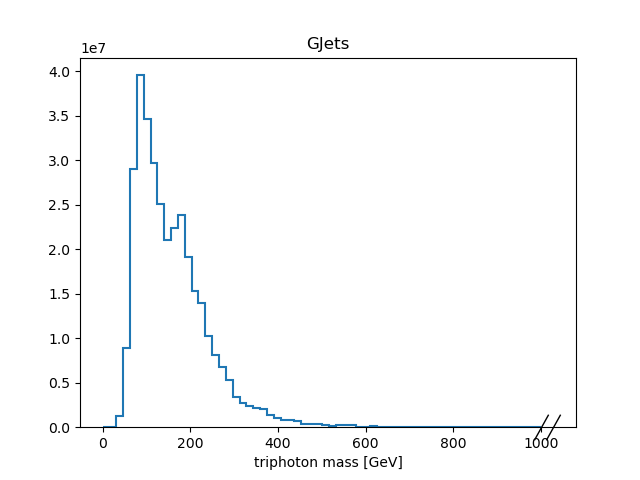

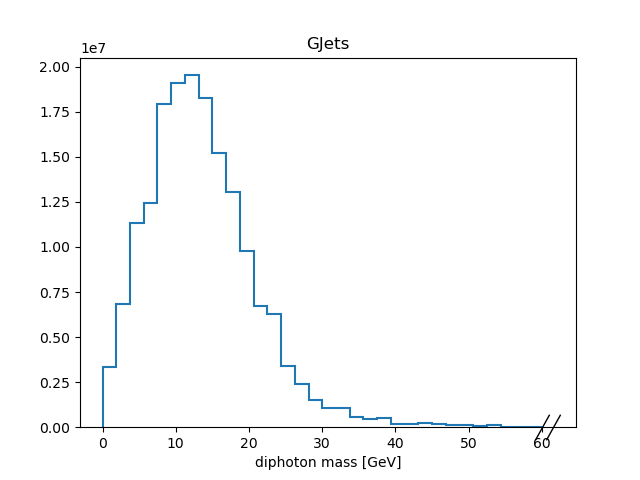

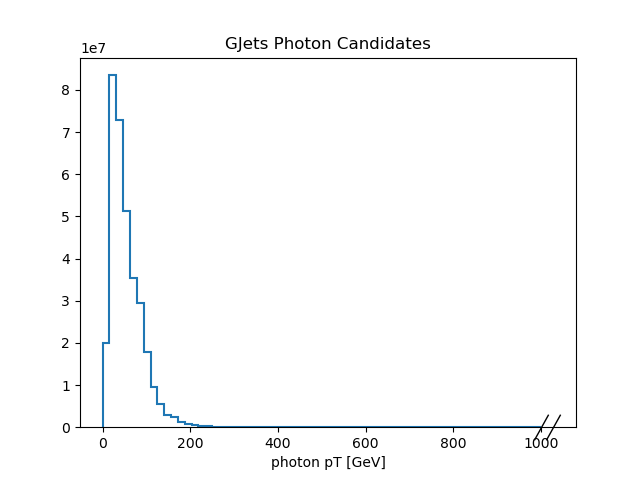

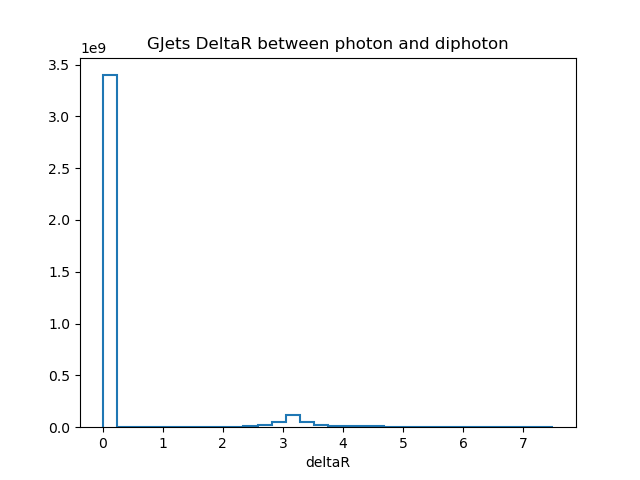

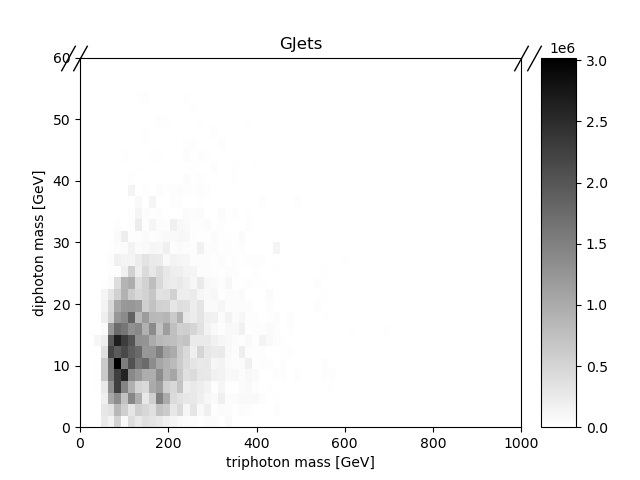

In [7]:
importlib.reload(p)
plot_dir = '../plots/bkg/'
p.plot1d(scaled_hists['triphoton_mass'], title='GJets', save_as=plot_dir+'GJets_triphoton_mass.png')
p.plot1d(scaled_hists['diphoton_mass'], title='GJets', save_as=plot_dir+'GJets_diphoton_mass.png')
p.plot1d(scaled_hists['photon_pt'], title='GJets Photon Candidates', save_as=plot_dir+'GJets_photon_pt.png')
p.plot1d(scaled_hists['dr'], title='GJets DeltaR between photon and diphoton', save_as=plot_dir+'GJets_dr.png')
p.plot2d(scaled_hists['triphoton_diphoton_mass'], title='GJets', save_as=plot_dir+'GJets_triphoton_diphoton_mass.png')

In [ ]:
plot1d(hists['diphoton_mass']['GJets_HT-600ToInf'], title='lead diphoton mass')
plot1d(hists['triphoton_mass']['GJets_HT-600ToInf'], title='triphoton mass')

IndexError: Wrong number of indices for histogram